In [1]:
# get required packages

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Using Google Colab
from google.colab import drive
drive.mount("/content/gdrive", force_remount =True)

dataset_path ="/content/gdrive/My Drive/Colab-Notebooks/PA Project/"
%cd "gdrive/My Drive/Colab-Notebooks/PA Project/"

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab-Notebooks/PA Project


In [3]:
# Zillow data for home sales from 1996 to 2018 by state,city
# load the data into data frame
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# The real estate market is very hot in california due to job market 
# so will analyze the california data
ca=df[(df['State']=='CA')]

In [5]:
area = pd.read_csv('California_zip.csv')
area.head()

,RegionName,District
0,90001,Los Angeles
1,90002,Los Angeles
2,90003,Los Angeles
3,90004,Los Angeles
4,90005,Los Angeles


In [6]:
ca1 = pd.merge(ca, area, how='left', on='RegionName')

In [7]:
ca1.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,District
0,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,766000.0,771100.0,776500.0,...,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500,San Francisco
1,96107,90250,Hawthorne,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,16,152500.0,152600.0,152600.0,...,585700,590900,594700,598500,601300,602800,606100,612400,616200,Hawthorne
2,97771,94565,Pittsburg,CA,San Francisco,Contra Costa,28,139200.0,138300.0,137500.0,...,398400,401600,405400,408600,410900,413700,417900,424300,430100,Pittsburg
3,96027,90046,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,31,340600.0,341700.0,343000.0,...,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900,Los Angeles
4,97711,94501,Alameda,CA,San Francisco,Alameda,65,222400.0,222300.0,222400.0,...,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700,Alameda


In [8]:
# Reformat wide to long format & Data processing
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','City','Metro','CountyName'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y-%m')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [9]:
# Drop variables which we do not need
ca2 = ca1.drop(['RegionID','State','SizeRank','District'], axis ='columns')
ca2.head()

,RegionName,City,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,94109,San Francisco,San Francisco,San Francisco,766000.0,771100.0,776500.0,781900.0,787300.0,793000.0,...,3767700,3763900,3775000,3799700,3793900,3778700,3770800,3763100,3779800,3813500
1,90250,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles,152500.0,152600.0,152600.0,152600.0,152600.0,152600.0,...,579300,585700,590900,594700,598500,601300,602800,606100,612400,616200
2,94565,Pittsburg,San Francisco,Contra Costa,139200.0,138300.0,137500.0,136600.0,135600.0,134700.0,...,394900,398400,401600,405400,408600,410900,413700,417900,424300,430100
3,90046,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles,340600.0,341700.0,343000.0,344400.0,346100.0,348000.0,...,1839800,1861100,1888600,1903900,1907500,1922100,1952400,1974500,1975900,1966900
4,94501,Alameda,San Francisco,Alameda,222400.0,222300.0,222400.0,222600.0,223000.0,223600.0,...,965100,975000,987800,1000000,1009900,1021000,1032400,1042000,1053000,1059700


In [10]:
dfm = melt_data(ca2)

In [11]:
dfm.head()

,RegionName,City,Metro,CountyName,Month,MeanValue
0,94109,San Francisco,San Francisco,San Francisco,1996-04-01,766000.0
1,90250,Hawthorne,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-04-01,152500.0
2,94565,Pittsburg,San Francisco,Contra Costa,1996-04-01,139200.0
3,90046,Los Angeles,Los Angeles-Long Beach-Anaheim,Los Angeles,1996-04-01,340600.0
4,94501,Alameda,San Francisco,Alameda,1996-04-01,222400.0


In [12]:
dfm.set_index('Month', inplace = True)

In [13]:
# fed_rate is the additional feature 
features = pd.read_csv('fed_rate.csv')
features.head()

,Month,Fed_Rate
0,2011-01-01,0.13
1,2011-02-01,0.18
2,2011-03-01,0.15
3,2011-04-01,0.11
4,2011-05-01,0.09


In [14]:
dfm.dtypes

RegionName      int64
City           object
Metro          object
CountyName     object
MeanValue     float64
dtype: object

In [15]:
features['Month'] =  pd.to_datetime(features['Month'])

In [16]:
features.dtypes

Month       datetime64[ns]
Fed_Rate           float64
dtype: object

In [17]:
features.tail()

,Month,Fed_Rate
83,2017-12-01,1.16
84,2018-01-01,1.42
85,2018-02-01,1.42
86,2018-03-01,1.42
87,2018-04-01,1.67


In [18]:
dfm.tail()

,RegionName,City,Metro,CountyName,MeanValue
Month,,,,,
2018-04-01,93517,Bridgeport,NaN,Mono,272500.0
2018-04-01,95728,Truckee,Truckee,Nevada,496300.0
2018-04-01,95497,Annapolis,Santa Rosa,Sonoma,848700.0
2018-04-01,92322,Crestline,Riverside,San Bernardino,200100.0
2018-04-01,92341,Green Valley Lake,Riverside,San Bernardino,183600.0


In [19]:
dfm_fea = pd.merge(dfm, features, how='left', on='Month')

#df_train_new = dfm.merge(features, on=['Month'], how = 'left')
#dfm_fea = pd.concat([dfm, features]) #, how='left', on = 'Month')

In [20]:
dfm_fea.tail()

,Month,RegionName,City,Metro,CountyName,MeanValue,Fed_Rate
318739,2018-04-01,93517,Bridgeport,NaN,Mono,272500.0,1.67
318740,2018-04-01,95728,Truckee,Truckee,Nevada,496300.0,1.67
318741,2018-04-01,95497,Annapolis,Santa Rosa,Sonoma,848700.0,1.67
318742,2018-04-01,92322,Crestline,Riverside,San Bernardino,200100.0,1.67
318743,2018-04-01,92341,Green Valley Lake,Riverside,San Bernardino,183600.0,1.67


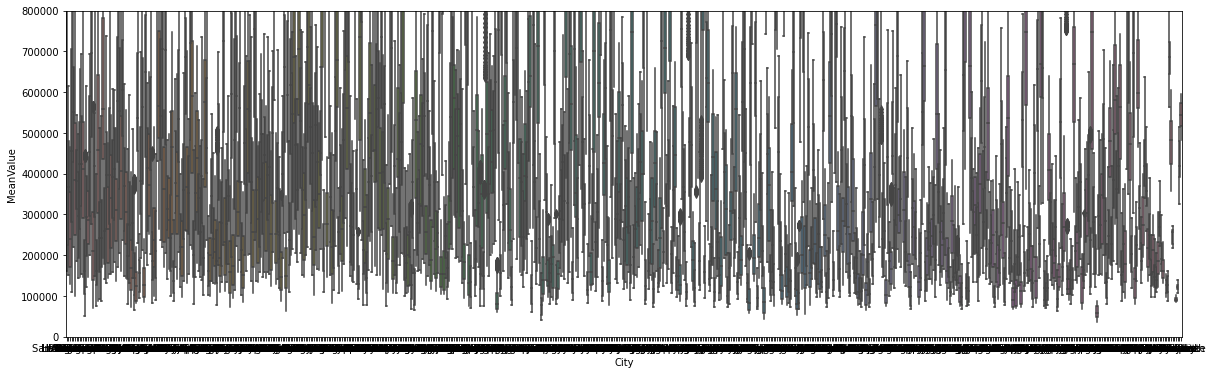

In [21]:
# now see the relation between city and Mean value 
var = 'City'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

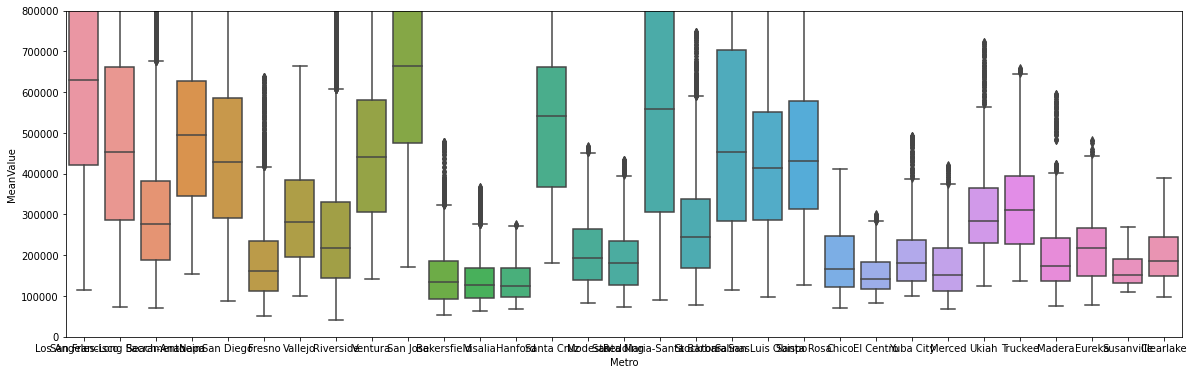

In [22]:
# now see the relation between Metro and Mean value 
var = 'Metro'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

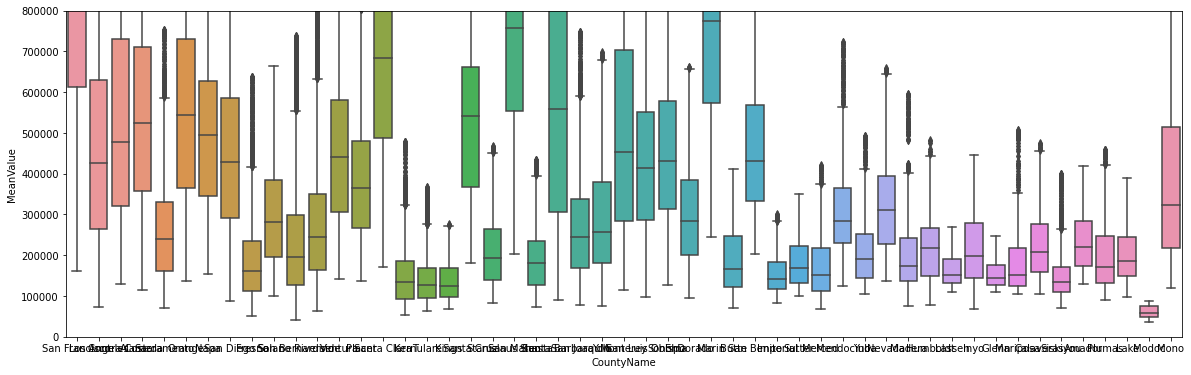

In [23]:
var = 'CountyName'
data = pd.concat([dfm_fea['MeanValue'],dfm_fea[var]],axis=1)
f, ax = plt.subplots(figsize=(20, 6))
fig = sns.boxplot(x=var, y="MeanValue",data=data)
fig.axis(ymin=0,ymax=800000);

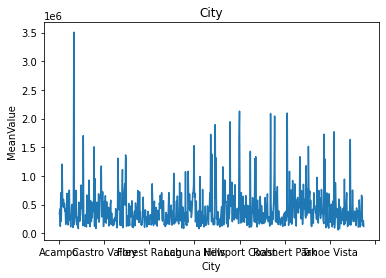

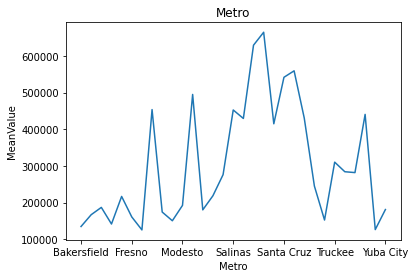

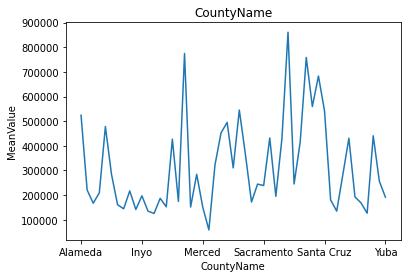

In [24]:
temporal_features = ['City','Metro','CountyName']

for feature in temporal_features:
    data = dfm_fea.copy()
    
    dfm_fea.groupby(feature)['MeanValue'].median().plot()
    plt.xlabel(feature)
    plt.ylabel('MeanValue')
    plt.title(feature)
    plt.show()

In [25]:
# since we have many cities we focus on single city
# will focus just on San Francisco and give suggestions from that city only, since many visitors come to SFO to visit, so that is better
#place to invest, so focus on this city


In [26]:
ca3 = dfm_fea[dfm_fea['City']=='San Francisco']
ca3.head(5)

,Month,RegionName,City,Metro,CountyName,MeanValue,Fed_Rate
0,1996-04-01,94109,San Francisco,San Francisco,San Francisco,766000.0,NaN
6,1996-04-01,94110,San Francisco,San Francisco,San Francisco,213900.0,NaN
56,1996-04-01,94122,San Francisco,San Francisco,San Francisco,278400.0,NaN
91,1996-04-01,94112,San Francisco,San Francisco,San Francisco,210100.0,NaN
132,1996-04-01,94115,San Francisco,San Francisco,San Francisco,794000.0,NaN


In [27]:
# since we can get discrete values from zip code we can delete Metro,city and CountyName
ca4 = ca3.drop(['Metro','CountyName','City'], axis ='columns')
ca4.tail()

,Month,RegionName,MeanValue,Fed_Rate
317971,2018-04-01,94133,3014600.0,1.67
318062,2018-04-01,94134,948200.0,1.67
318096,2018-04-01,94132,1344700.0,1.67
318119,2018-04-01,94124,888200.0,1.67
318294,2018-04-01,94127,1758400.0,1.67


In [28]:
# from dfm also remove all other cities other than Dallas 

In [29]:
dfm1 = ca4

In [30]:
dfm1.tail()

,Month,RegionName,MeanValue,Fed_Rate
317971,2018-04-01,94133,3014600.0,1.67
318062,2018-04-01,94134,948200.0,1.67
318096,2018-04-01,94132,1344700.0,1.67
318119,2018-04-01,94124,888200.0,1.67
318294,2018-04-01,94127,1758400.0,1.67


In [31]:
dfm1.set_index('Month', inplace = True)

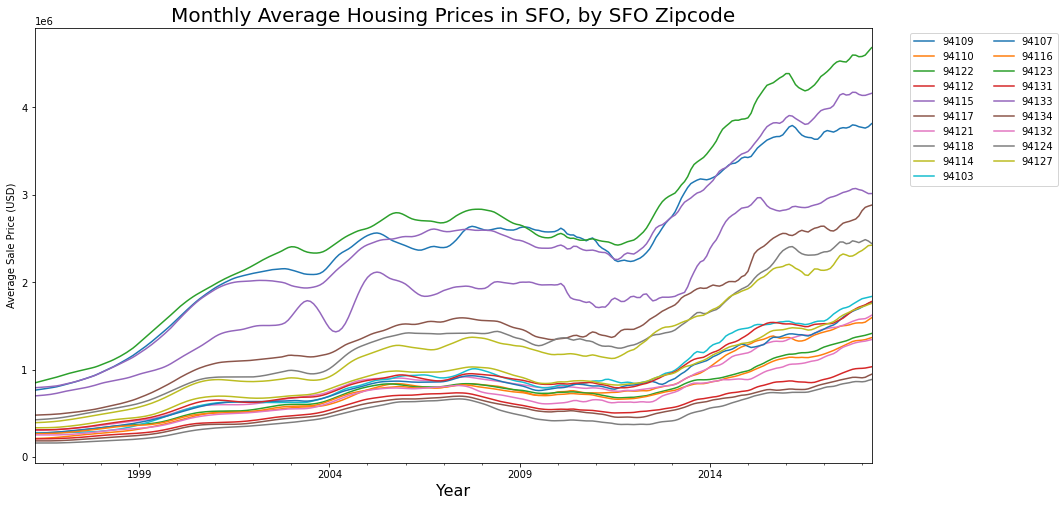

In [32]:
#EDA and Visualization

for zipcode in dfm1.RegionName.unique():
    temp_df = dfm1[dfm1.RegionName == zipcode]
    temp_df['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices in SFO, by SFO Zipcode', fontsize = 20);

41 zip codes have data from 1996 to 2018, however, There was a dip from 2008 and 2010 because of the financial crisis, housing price became stable around 2011.

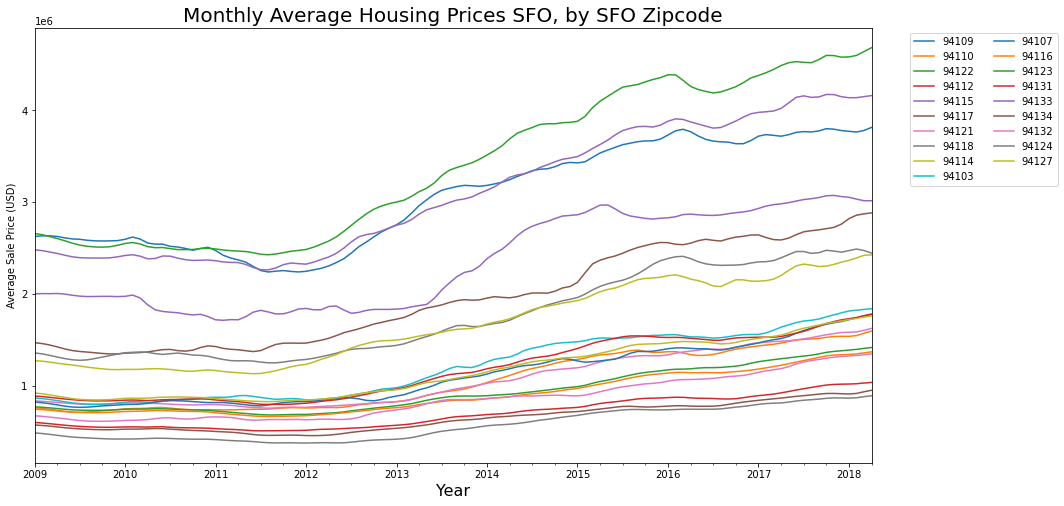

In [33]:
#A deeper look at 2008 above
for zipcode in dfm1.RegionName.unique():
    temp_df = dfm1[dfm1.RegionName == zipcode]
    temp_df['2009':]['MeanValue'].plot(figsize = (15,8), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices SFO, by SFO Zipcode', fontsize = 20);

In [34]:
#To get more accurate prediction on future data, we decided to use data 2011-Present.
df2011 = dfm1['2011':]


In [35]:
# now split data into train and test data set 
train_df = df2011[:int(0.8*(len(df2011)))]
test_df = df2011[int(0.8*(len(df2011))):]

In [36]:
test_df.tail()

,RegionName,MeanValue,Fed_Rate
Month,,,
2018-04-01,94133,3014600.0,1.67
2018-04-01,94134,948200.0,1.67
2018-04-01,94132,1344700.0,1.67
2018-04-01,94124,888200.0,1.67
2018-04-01,94127,1758400.0,1.67


In [37]:
train_month_avg = train_df.groupby('Month')['MeanValue'].mean()

In [38]:
train_month_avg.head()

Month
2011-01-01    1.124511e+06
2011-02-01    1.115047e+06
2011-03-01    1.109189e+06
2011-04-01    1.104174e+06
2011-05-01    1.098742e+06
Name: MeanValue, dtype: float64

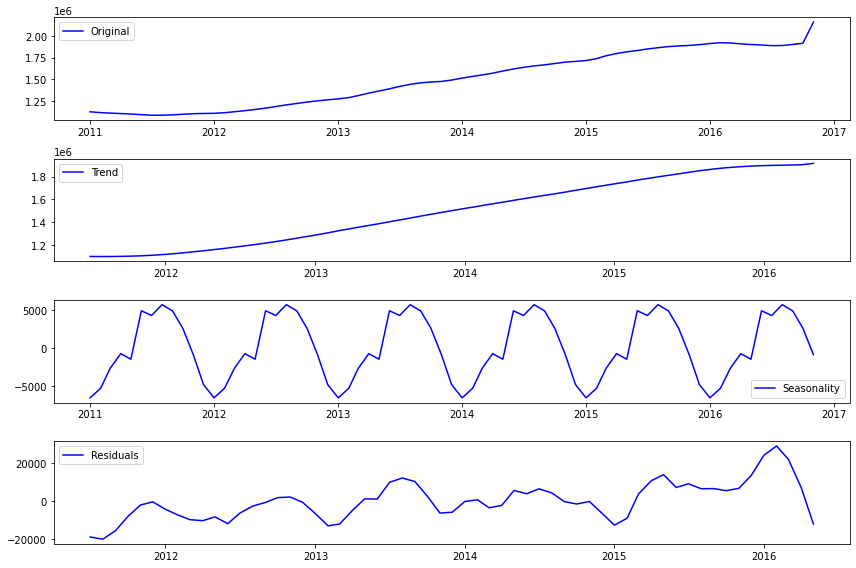

In [39]:
# now check the seasonality in train data set 
decomposition = sm.tsa.seasonal_decompose(train_month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(train_month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

An upward trend is present with yearly sesasonal changes.So we have seasonality in this

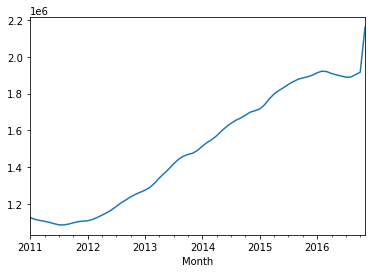

In [40]:
train_month_avg.plot()

In [41]:
train = train_df['MeanValue']
test = test_df['MeanValue']

In [42]:
train.tail()

Month
2016-11-01    1223700.0
2016-11-01     867500.0
2016-11-01    3926000.0
2016-11-01    2626500.0
2016-11-01    1436400.0
Name: MeanValue, dtype: float64

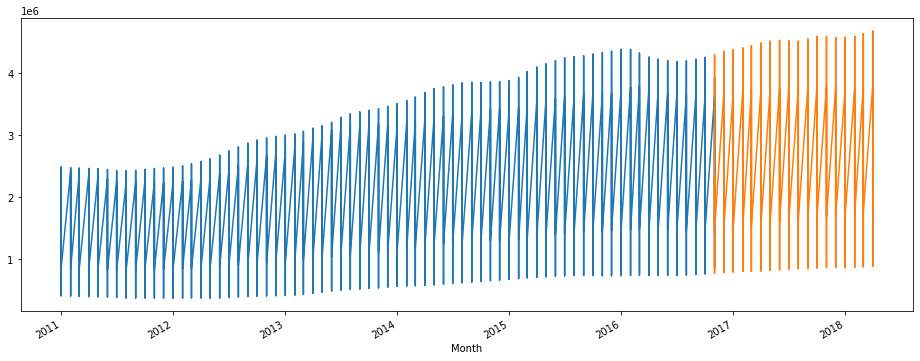

In [43]:
# prediction with out any additional variables 
train.plot(figsize=(16,6))
test.plot(figsize=(16,6))
plt.show()

The monthly average house price of Texas increased year over year. Now check acf and pacf.

In [44]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [45]:
adf_test(train_month_avg)

ADF Statistics: 2.3113032190178675
p- value: 0.9989622513679852
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#Now check Auto correlation

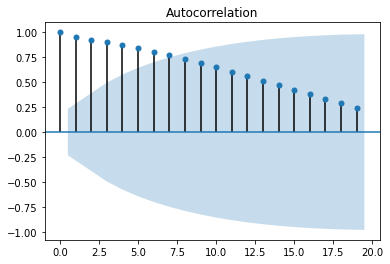

In [46]:
acf = plot_acf(train_month_avg)

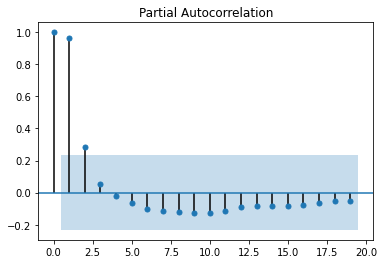

In [47]:
pacf = plot_pacf(train_month_avg)

In [48]:
#plot_acf(train_month_avg); plt.xlim(0,24); plt.show()
#plot_pacf(train_month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

from above ACF there is no autocorrelation so If take lag = 2 and lag = 3 difference to Autocorrlation to appear. So using lag = 3 for our analysis

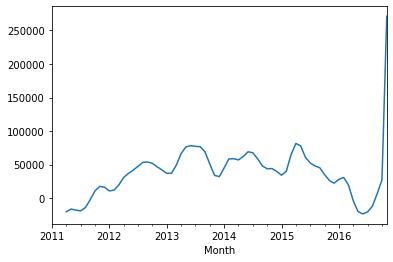

In [49]:
train_month_avg.diff(periods=3).plot()

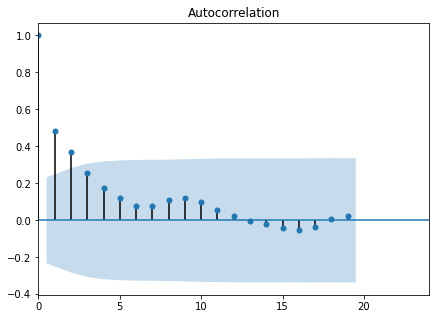

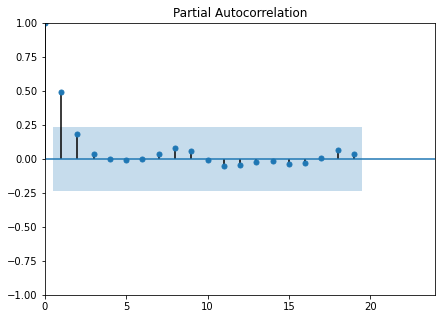

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize']=7,5
plot_acf(train_month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(train_month_avg.diff(periods=3).bfill()); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

 From above ACF and PACF we can tell this has AR1 and MA 2 process

Step 4: Initial SARIMA Models on Sample Zip Codes

In [51]:
dfm1.RegionName.unique()

array([94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114,
       94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124,
       94127])

In [52]:
#Select 5 zipcodes to check best model 
zip_dfs = []
zip_list = np.array([94109, 94110, 94122, 94112, 94115])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm1[dfm1['RegionName']==x][['MeanValue']].copy()))


In [53]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [54]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [55]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

Result for 94109 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 8537.222003188986
Result for 94109 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 7996.685713606439
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 6966.647693921467
Result for 94109 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6594.707974147812
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated = 6924.623646586941
Result for 94109 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6877.4748079020155
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 6602.114335598667
Result for 94109 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 6569.97500070989
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 8313.85679446212
Result for 94109 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7892.074296338371
Result for 94109 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 7122.416961629124
Result for 94109 ARIMA (0, 0, 1) 

In [56]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

The Akaike Information Critera (AIC) is a widely used measure of a statistical model. It basically quantifies 1) the goodness of fit, and 2) the simplicity/parsimony, of the model into a single statistic.

When comparing two models, the one with the lower AIC is generally “better”.

In [57]:
#Return the best set of parameters based on AIC
best_parameters = result.loc[result.groupby("name")["AIC"].idxmin()]

In [58]:
# best parameters for first 10 zip codes 
best_parameters.head(10)

,name,pdq,pdqs,AIC
63,94109,"(1, 1, 1)","(1, 1, 1, 12)",5213.913980
127,94110,"(1, 1, 1)","(1, 1, 1, 12)",4615.661859
255,94112,"(1, 1, 1)","(1, 1, 1, 12)",4300.348734
319,94115,"(1, 1, 1)","(1, 1, 1, 12)",5142.710302
191,94122,"(1, 1, 1)","(1, 1, 1, 12)",4382.309140


In [59]:
# from above results the best model is (1,1,1) and (1,1,1,12) for seasonal
# so use that to model train and fit test 
model_SARIMA = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12))
model_SARIMA_fit = model_SARIMA.fit()
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          MeanValue   No. Observations:                 1337
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -20150.077
Date:                            Thu, 21 Apr 2022   AIC                          40310.153
Time:                                    17:09:46   BIC                          40336.095
Sample:                                         0   HQIC                         40319.878
                                           - 1337                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      0.075     -1.364      0.173      -0.249       0.045
ma.L1         -0.9955      0.022    -45.238      0.000      -1.039      -0.952
ar.S.L12       0.2609      0.067      3.905      0.000       0.130       0.392
ma.S.L12      -0.9792      0.053    -18.356      0.000      -1.084      -0.875
sigma2      1.629e+12   1.51e-14   1.08e+26      0.000    1.63e+12    1.63e+12
===================================================================================
Ljung-Box (Q):                     4056.44   Jarque-Bera (JB):               132.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.59e+41. Standard errors may be unstable.
"""

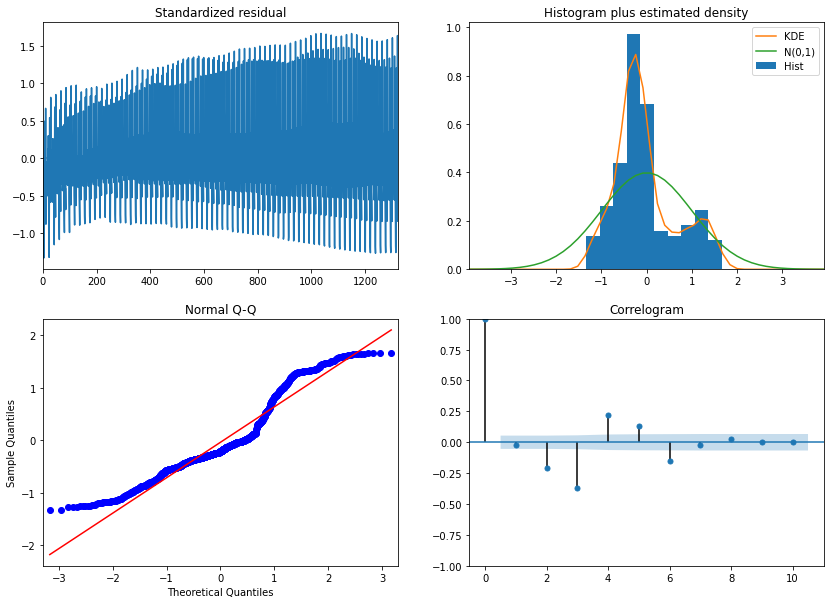

In [60]:
model_SARIMA_fit.plot_diagnostics(figsize=(14,10));

Plug the optimal parameter values into a new SARIMAX model to have a deeper look

In [61]:
# plug the optimal parameter values into a new SARIMAX model.

for name, pdq, pdqs, df in zip(best_parameters['name'], best_parameters['pdq'], best_parameters['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()
    print('SARIMA Model Result for {}'.format(name))
    print(output.summary().tables[1])
                           
                           
# Fit the model and print results

SARIMA Model Result for 94109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7772      0.048     16.310      0.000       0.684       0.871
ma.L1          0.3972      0.028     14.422      0.000       0.343       0.451
ar.S.L12      -0.4302      0.069     -6.198      0.000      -0.566      -0.294
ma.S.L12      -0.0352      0.054     -0.653      0.514      -0.141       0.070
sigma2      2.003e+08   1.08e-10   1.85e+18      0.000       2e+08       2e+08
SARIMA Model Result for 94110
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7868      0.027     29.066      0.000       0.734       0.840
ma.L1          0.7128      0.029     24.811      0.000       0.656       0.769
ar.S.L12       0.3150      0.080      3.947      0.000       0.159     

Make dynamic forecast using data up to 2017-01-01 and compare with real values post 2017-01-01

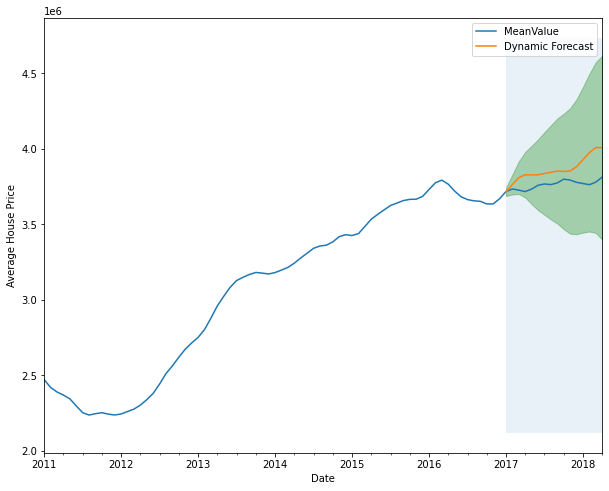

The Mean Squared Error of our forecasts is 119524.68


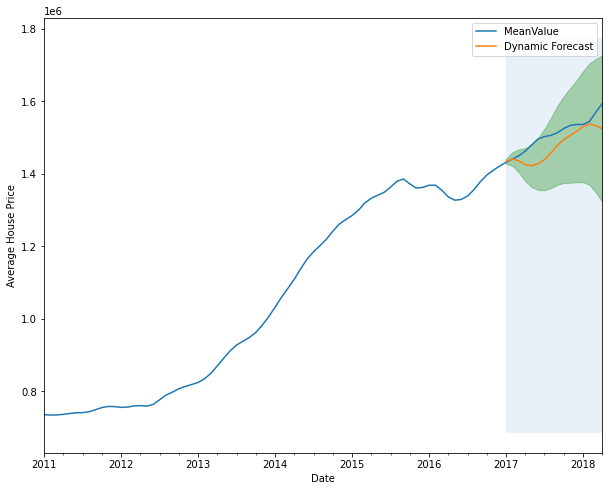

The Mean Squared Error of our forecasts is 39920.73


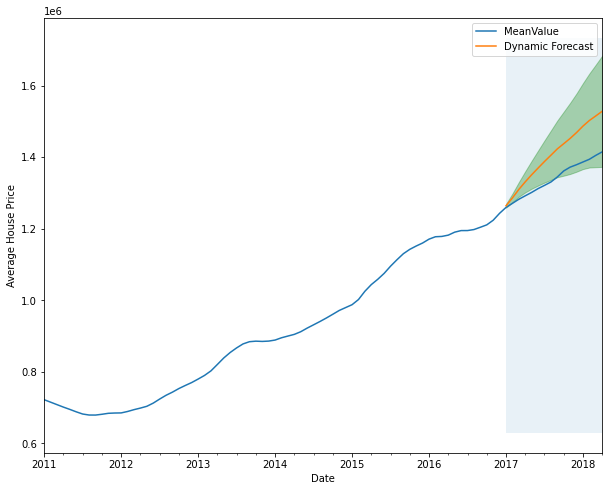

The Mean Squared Error of our forecasts is 75657.66


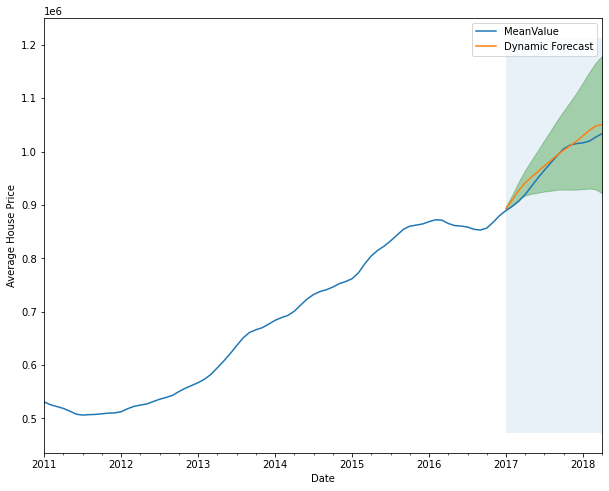

The Mean Squared Error of our forecasts is 13519.66


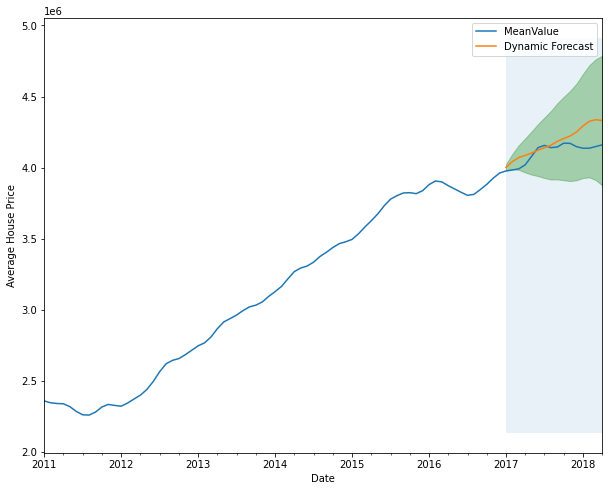

The Mean Squared Error of our forecasts is 99249.46


In [62]:
#Make Prediction post 2017 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_parameters['name'], best_parameters['pdq'], best_parameters['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-01':]['MeanValue']
    
    #Plot the dynamic forecast with confidence intervals as above
    ax = df['2011':].plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-01'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Date')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()
    
     #print(type(zip_forecasted))
    #print(zip_truth)
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value
      

In [63]:
summary_table

,Zipcode,Sqrt_MSE
0,94109,119524.680070
1,94110,39920.725080
2,94112,75657.658316
3,94115,13519.660121
4,94122,99249.458080


In [64]:
# now fit the model with additional variables
model_SARIMA_1 = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12),exog = train_df[['Fed_Rate']])
model_SARIMA_fit_1 = model_SARIMA_1.fit()
model_SARIMA_fit_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                          MeanValue   No. Observations:                 1337
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -20149.982
Date:                            Thu, 21 Apr 2022   AIC                          40311.963
Time:                                    17:10:09   BIC                          40343.093
Sample:                                         0   HQIC                         40323.633
                                           - 1337                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fed_Rate    5.025e+05   7.17e-10   7.01e+14      0.000    5.02e+05    5.02e+05
ar.L1         -0.1023      0.077     -1.329      0.184      -0.253       0.048
ma.L1         -0.9935      0.014    -69.283      0.000      -1.022      -0.965
ar.S.L12       0.2624      0.066      3.972      0.000       0.133       0.392
ma.S.L12      -0.9788      0.053    -18.594      0.000      -1.082      -0.876
sigma2      1.629e+12   1.42e-14   1.14e+26      0.000    1.63e+12    1.63e+12
===================================================================================
Ljung-Box (Q):                     4067.89   Jarque-Bera (JB):               127.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+42. Standard errors may be unstable.
"""

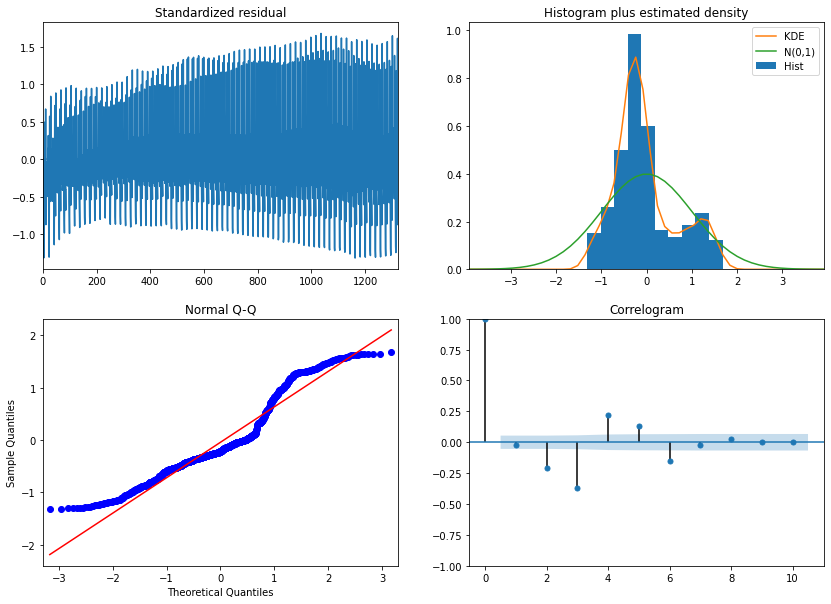

In [65]:
model_SARIMA_fit_1.plot_diagnostics(figsize=(14,10));

# LSTM

In [66]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
seed(1)

In [67]:
lstm_df = pd.DataFrame(df2011['Fed_Rate'])
lstm_df = np.array(lstm_df)

In [68]:
train_size = int(len(lstm_df) * 0.8)
val_size = len(lstm_df) - train_size
train, val = lstm_df[0:train_size,:], lstm_df[train_size:len(lstm_df),:]

In [69]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

In [71]:
val = scaler.fit_transform(val)

In [72]:
# Lookback period
lookback = 5
X_train, Y_train = create_dataset(train, lookback)
X_val, Y_val = create_dataset(val, lookback)

In [73]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [74]:
import tensorflow as tf

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=10, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())

Epoch 1/10
1064/1064 - 4s - loss: 0.0044 - val_loss: 0.0078 - 4s/epoch - 4ms/step
Epoch 2/10
1064/1064 - 2s - loss: 0.0012 - val_loss: 0.0053 - 2s/epoch - 2ms/step
Epoch 3/10
1064/1064 - 2s - loss: 0.0011 - val_loss: 0.0057 - 2s/epoch - 2ms/step
Epoch 4/10
1064/1064 - 2s - loss: 9.4040e-04 - val_loss: 0.0040 - 2s/epoch - 2ms/step
Epoch 5/10
1064/1064 - 2s - loss: 8.4799e-04 - val_loss: 0.0042 - 2s/epoch - 2ms/step
Epoch 6/10
1064/1064 - 2s - loss: 7.7614e-04 - val_loss: 0.0043 - 2s/epoch - 2ms/step
Epoch 7/10
1064/1064 - 2s - loss: 6.9868e-04 - val_loss: 0.0067 - 2s/epoch - 2ms/step
Epoch 8/10
1064/1064 - 2s - loss: 6.5452e-04 - val_loss: 0.0075 - 2s/epoch - 2ms/step
Epoch 9/10
1064/1064 - 2s - loss: 6.2642e-04 - val_loss: 0.0064 - 2s/epoch - 2ms/step
Epoch 10/10
1064/1064 - 2s - loss: 5.9353e-04 - val_loss: 0.0046 - 2s/epoch - 2ms/step
dict_keys(['loss', 'val_loss'])


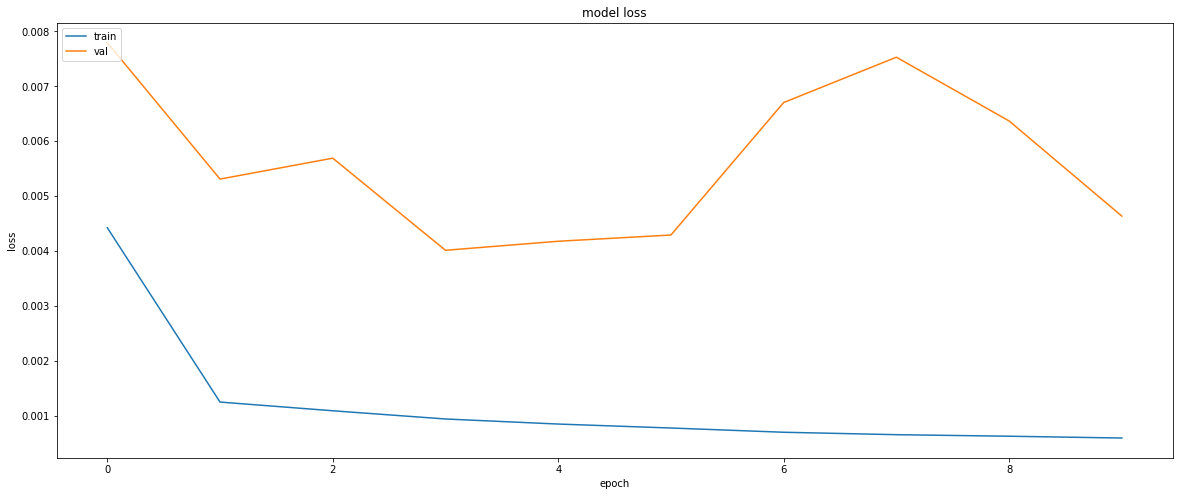

In [75]:
# summarize history for accuracy
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [77]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [78]:
import math

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 0.05 RMSE
Validation Score: 0.04 RMSE


In [79]:
# Train predictions
trainpredPlot = np.empty_like(lstm_df)
trainpredPlot[:, :] = np.nan
trainpredPlot[lookback:len(trainpred)+lookback, :] = trainpred

In [80]:
# Validation predictions
valpredPlot = np.empty_like(lstm_df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(lookback*2)+1:len(lstm_df)-1, :] = valpred

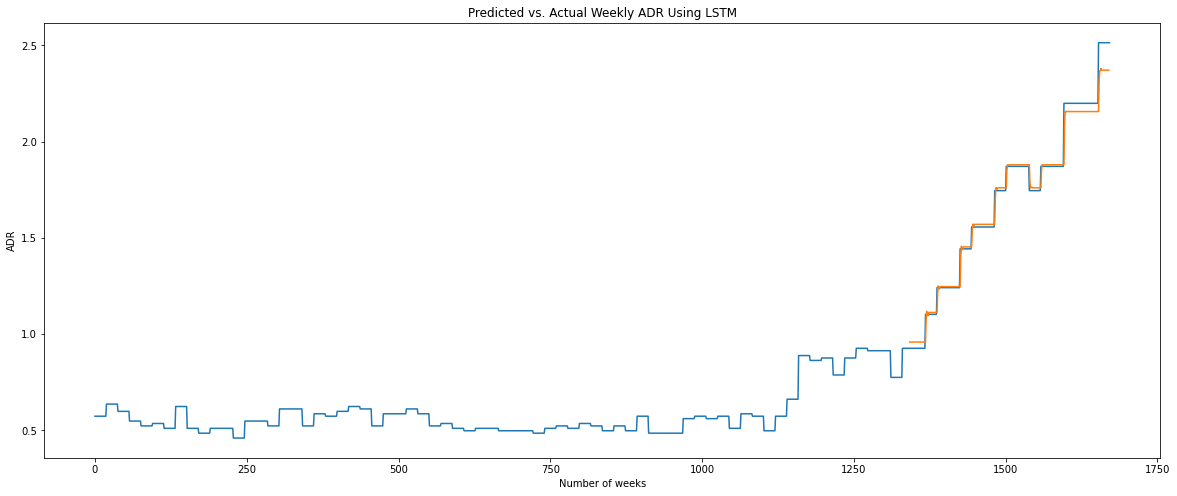

In [81]:
# Plot all predictions
plt.figure(figsize=(20,8))
inversetransform, =plt.plot(scaler.inverse_transform(lstm_df))
valpred, =plt.plot(scaler.inverse_transform(valpredPlot))
plt.xlabel('Number of weeks')
plt.ylabel('ADR')
plt.title("Predicted vs. Actual Weekly ADR Using LSTM")
plt.show()

In [82]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [83]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [84]:
mse = mean_squared_error(Y_val, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.042097


# FB Prophet

In [85]:
#Loading our dataset for zipcodes 94109, 94110, 94122, 94112, 94115
##Train
train_1=train_df[train_df['RegionName']==94109].drop(['Fed_Rate', 'RegionName'], axis=1)
train_2=train_df[train_df['RegionName']==94110].drop(['Fed_Rate', 'RegionName'], axis=1)
train_3=train_df[train_df['RegionName']==94122].drop(['Fed_Rate', 'RegionName'], axis=1)
train_4=train_df[train_df['RegionName']==94112].drop(['Fed_Rate', 'RegionName'], axis=1)
train_5=train_df[train_df['RegionName']==94115].drop(['Fed_Rate', 'RegionName'], axis=1)


#Test
test_1=test_df[test_df['RegionName']==94109].drop(['Fed_Rate', 'RegionName'], axis=1)
test_2=test_df[test_df['RegionName']==94110].drop(['Fed_Rate', 'RegionName'], axis=1)
test_3=test_df[test_df['RegionName']==94122].drop(['Fed_Rate', 'RegionName'], axis=1)
test_4=test_df[test_df['RegionName']==94112].drop(['Fed_Rate', 'RegionName'], axis=1)
test_5=test_df[test_df['RegionName']==94115].drop(['Fed_Rate', 'RegionName'], axis=1)


In [86]:
#Convert Datasets to Format Required by Prophet
df1=train_1.reset_index()
df1.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df2=train_2.reset_index()
df2.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df3=train_3.reset_index()
df3.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df4=train_4.reset_index()
df4.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df5=train_5.reset_index()
df5.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)


In [87]:
from fbprophet import Prophet

#WITHOUT ADDITIONAL VARIABLE

Fit and Forecast for zipcode 94109

In [88]:
#Fit and Forecast for zipcode 94109
m = Prophet()
m.fit(df1)# df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=17, freq='M')
forecast = m.predict(future)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2011-01-01,2.442897e+06
1,2011-02-01,2.422260e+06
2,2011-03-01,2.363868e+06
3,2011-04-01,2.362935e+06
4,2011-05-01,2.352789e+06
...,...,...
83,2017-11-30,3.675353e+06
84,2017-12-31,3.746185e+06
85,2018-01-31,3.801762e+06
86,2018-02-28,3.611374e+06


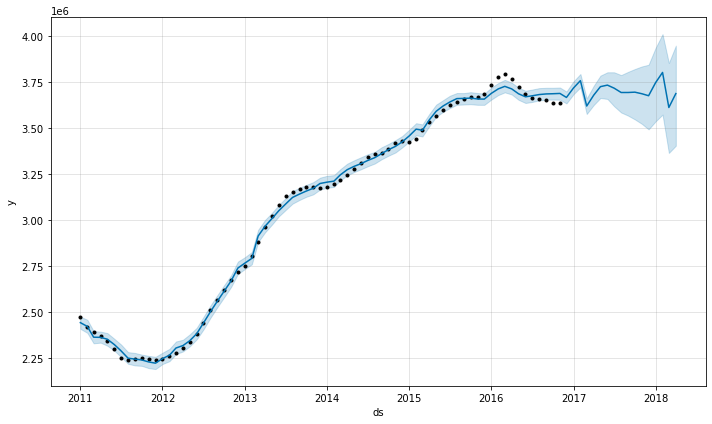

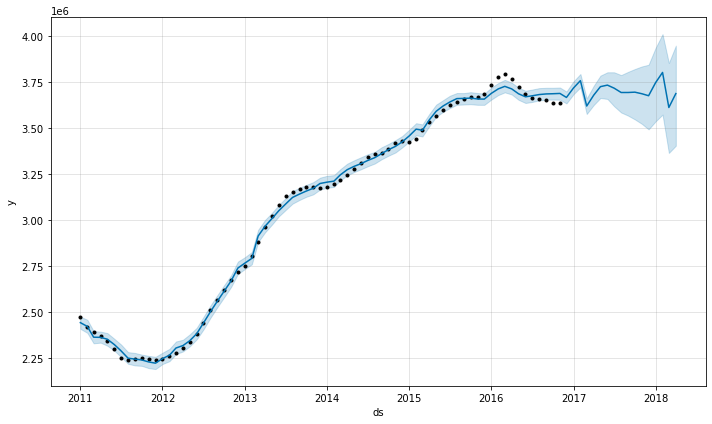

In [89]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 79928.73


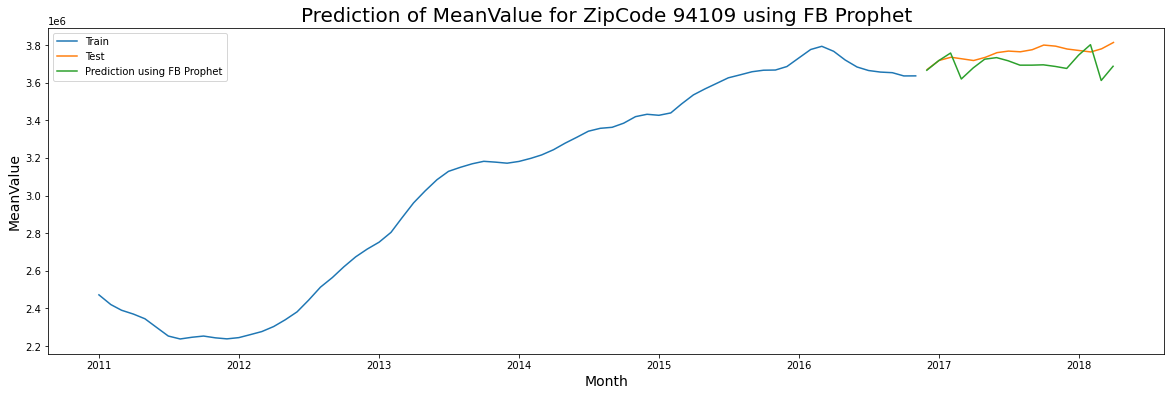

In [90]:
# Predicting the test values using predict function.
train = train_1['MeanValue'] 
forecast= forecast_pred
sqrt_mse1 =np.sqrt(mean_squared_error(test_1['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse1, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94109 using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_1, label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94110

In [91]:
#Fit and Forecast for zipcode 94110
m = Prophet()
m.fit(df2)# df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=17, freq='M')
forecast = m.predict(future)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2011-01-01,7.344532e+05
1,2011-02-01,7.342999e+05
2,2011-03-01,7.289011e+05
3,2011-04-01,7.296536e+05
4,2011-05-01,7.346822e+05
...,...,...
83,2017-11-30,1.378991e+06
84,2017-12-31,1.375889e+06
85,2018-01-31,1.367438e+06
86,2018-02-28,1.346724e+06


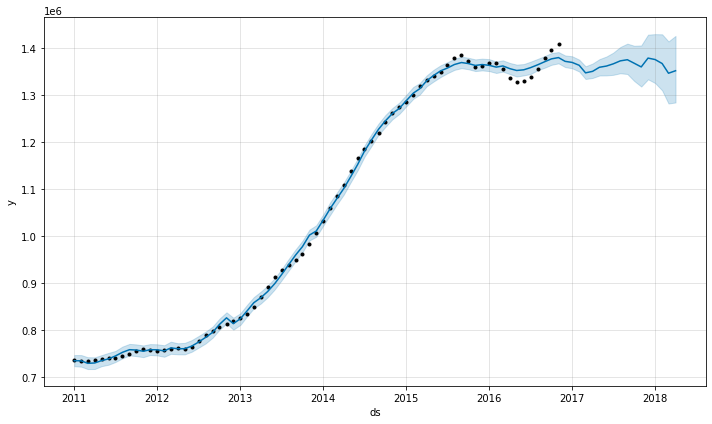

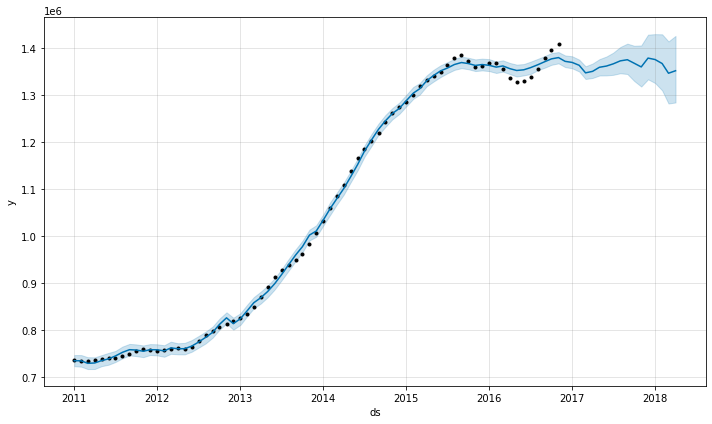

In [92]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 147193.85


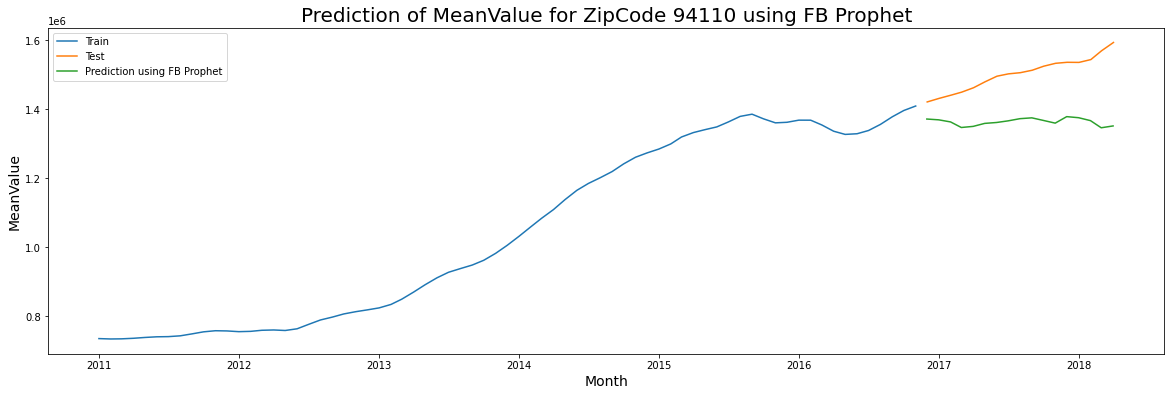

In [93]:
# Predicting the test values using predict function.
train = train_2['MeanValue'] 
forecast= forecast_pred
sqrt_mse2 =np.sqrt(mean_squared_error(test_2['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse2, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94110 using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_2, label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94122

In [94]:
#Fit and Forecast for zipcode 94122
m = Prophet()
m.fit(df3)# df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=17, freq='M')
forecast = m.predict(future)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2011-01-01,7.199667e+05
1,2011-02-01,7.146804e+05
2,2011-03-01,7.073032e+05
3,2011-04-01,7.025592e+05
4,2011-05-01,6.960119e+05
...,...,...
83,2017-11-30,1.311243e+06
84,2017-12-31,1.321076e+06
85,2018-01-31,1.332561e+06
86,2018-02-28,1.329397e+06


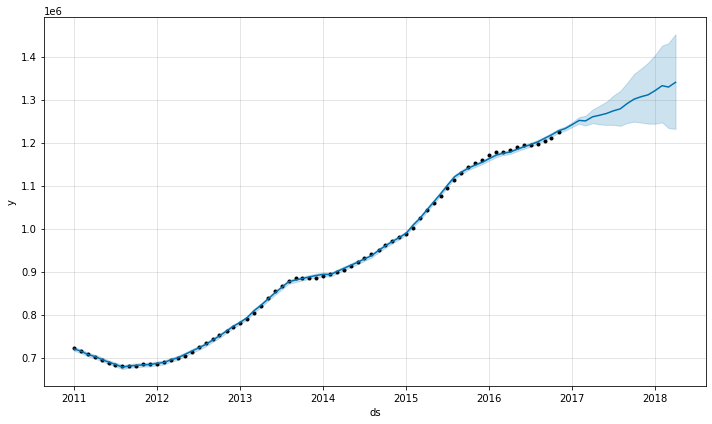

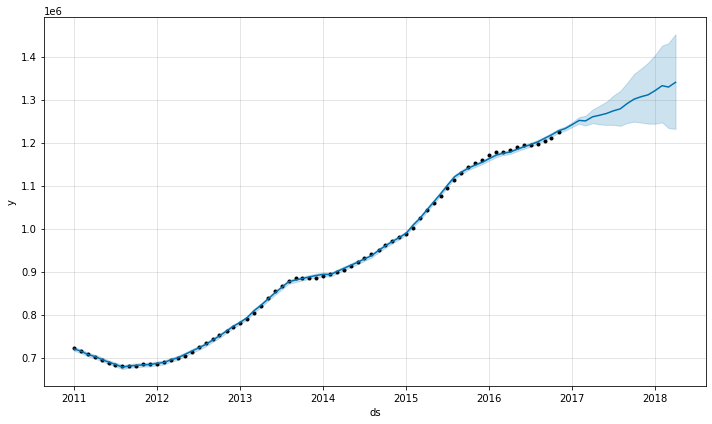

In [95]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 51833.51


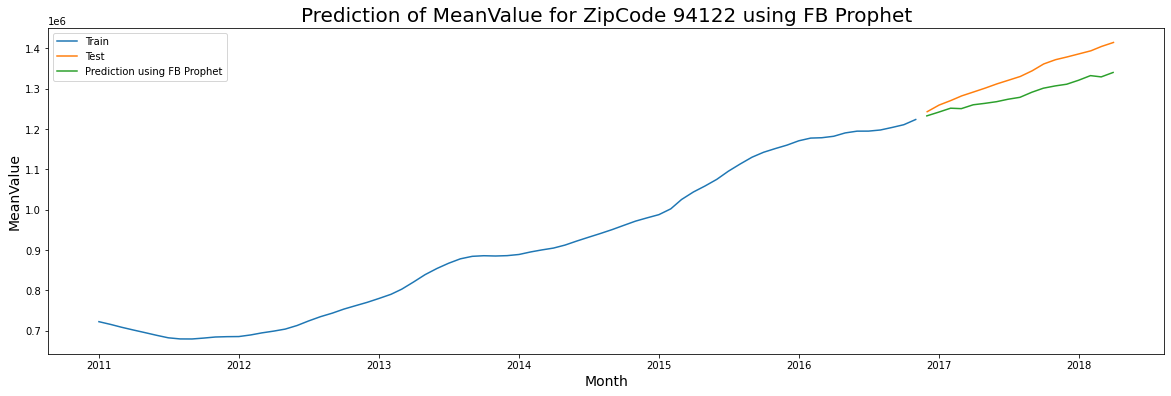

In [96]:
# Predicting the test values using predict function.
train = train_3['MeanValue'] 
forecast= forecast_pred
sqrt_mse3 =np.sqrt(mean_squared_error(test_3['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse3, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94122 using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_3, label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94112

In [97]:
#Fit and Forecast for zipcode 94122
m = Prophet()
m.fit(df4)# df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=17, freq='M')
forecast = m.predict(future)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2011-01-01,527501.965631
1,2011-02-01,524720.770250
2,2011-03-01,518438.977244
3,2011-04-01,517976.516418
4,2011-05-01,515776.248435
...,...,...
83,2017-11-30,870535.412065
84,2017-12-31,876028.314905
85,2018-01-31,886367.026011
86,2018-02-28,866530.294123


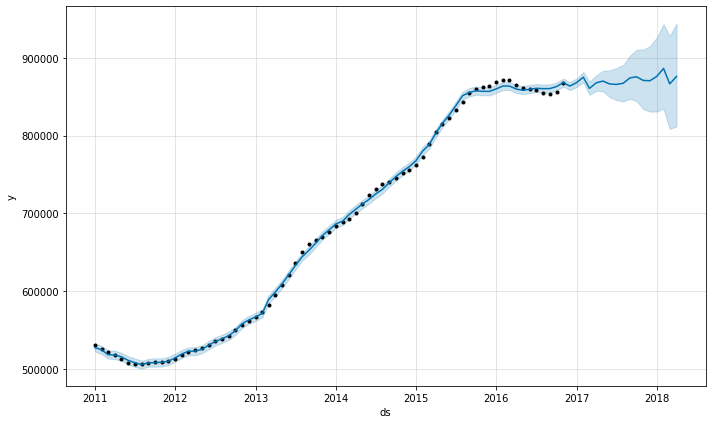

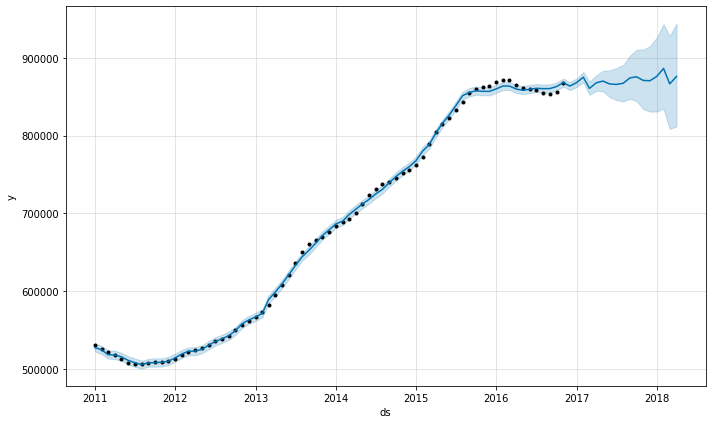

In [98]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 108336.93


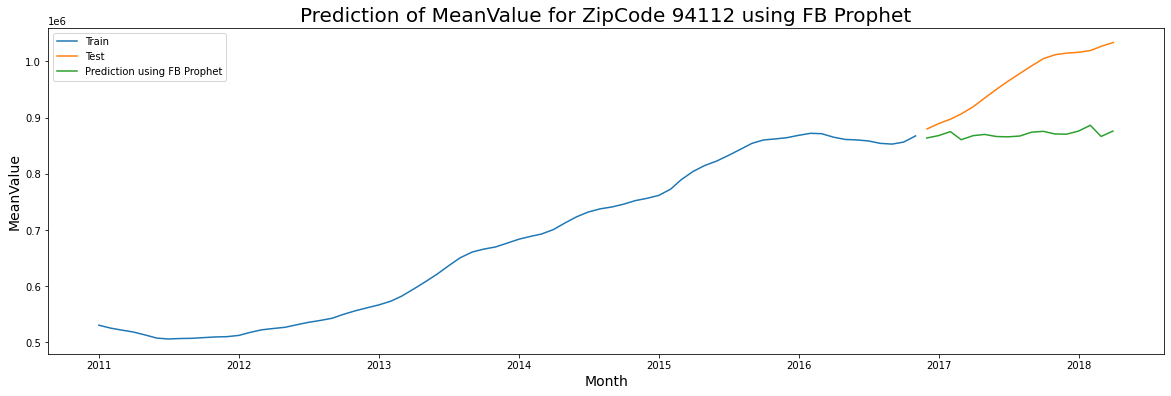

In [100]:
# Predicting the test values using predict function.
train = train_4['MeanValue'] 
forecast= forecast_pred
sqrt_mse4 =np.sqrt(mean_squared_error(test_4['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse4, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94112 using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_4, label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94115

In [101]:
#Fit and Forecast for zipcode 94115
m = Prophet()
m.fit(df5)# df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=17, freq='M')
forecast = m.predict(future)
forecast[['ds','yhat']]

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
0,2011-01-01,2.352368e+06
1,2011-02-01,2.346406e+06
2,2011-03-01,2.320018e+06
3,2011-04-01,2.326951e+06
4,2011-05-01,2.319577e+06
...,...,...
83,2017-11-30,3.936056e+06
84,2017-12-31,3.954970e+06
85,2018-01-31,3.986806e+06
86,2018-02-28,3.900352e+06


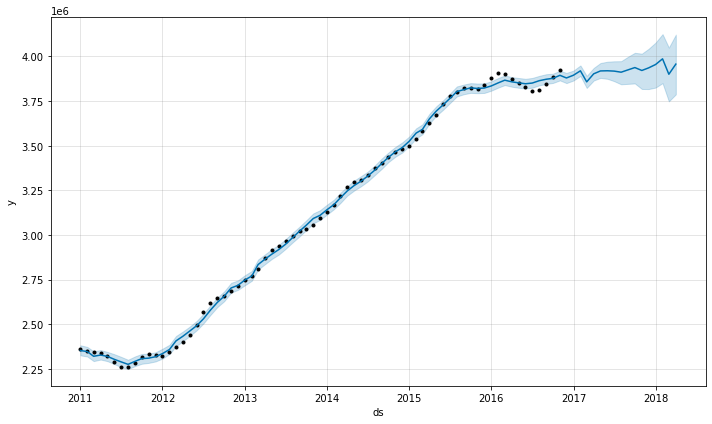

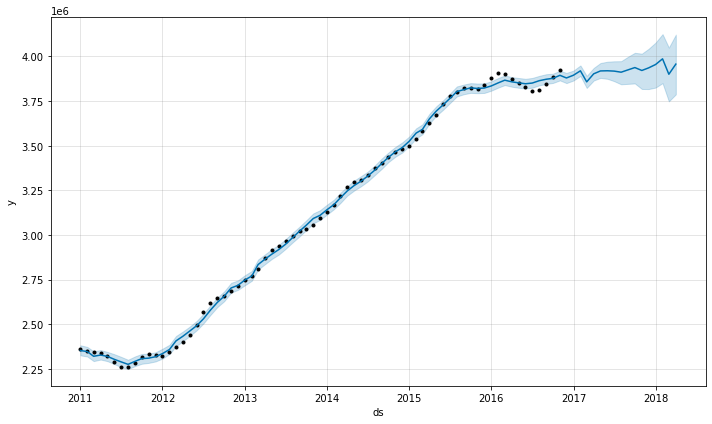

In [102]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 188450.58


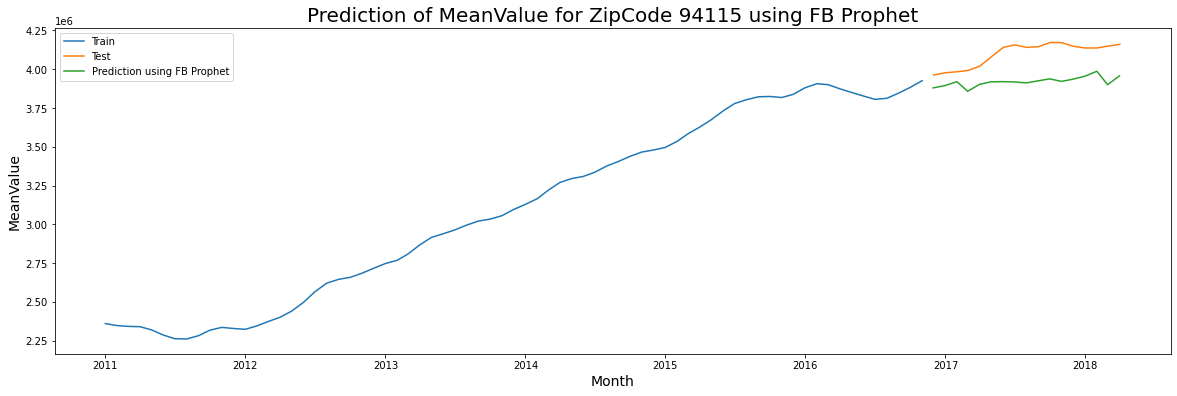

In [103]:
# Predicting the test values using predict function.
train = train_5['MeanValue'] 
forecast= forecast_pred
sqrt_mse5 =np.sqrt(mean_squared_error(test_5['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqrt_mse5, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94115 using FB Prophet', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_5, label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

In [104]:
data ={'ZipCode': ['94109','94110','94122','94112','94115'] ,'RMSE':[sqrt_mse1,sqrt_mse2,sqrt_mse3,sqrt_mse4,sqrt_mse5]}
fbp_mse=pd.DataFrame(data)
fbp_mse

,ZipCode,RMSE
0,94109,79928.731273
1,94110,147193.850165
2,94122,51833.507037
3,94112,108336.931033
4,94115,188450.584444


#WITH ADDITIONAL VARIABLE

In [105]:
#Loading our dataset for zipcodes 94109, 94110, 94122, 94112, 94115
##Train
train_1=train_df[train_df['RegionName']==94109].drop(['RegionName'], axis=1)
train_2=train_df[train_df['RegionName']==94110].drop([ 'RegionName'], axis=1)
train_3=train_df[train_df['RegionName']==94122].drop(['RegionName'], axis=1)
train_4=train_df[train_df['RegionName']==94112].drop(['RegionName'], axis=1)
train_5=train_df[train_df['RegionName']==94115].drop(['RegionName'], axis=1)

#Test
test_1=test_df[test_df['RegionName']==94109].drop(['RegionName'], axis=1)
test_2=test_df[test_df['RegionName']==94110].drop(['RegionName'], axis=1)
test_3=test_df[test_df['RegionName']==94122].drop([ 'RegionName'], axis=1)
test_4=test_df[test_df['RegionName']==94112].drop(['RegionName'], axis=1)
test_5=test_df[test_df['RegionName']==94115].drop(['RegionName'], axis=1)
train_1['Fed_Rate']

Month
2011-01-01    0.13
2011-02-01    0.18
2011-03-01    0.15
2011-04-01    0.11
2011-05-01    0.09
              ... 
2016-07-01    0.41
2016-08-01    0.40
2016-09-01    0.40
2016-10-01    0.29
2016-11-01    0.41
Name: Fed_Rate, Length: 71, dtype: float64

In [106]:
#Convert Datasets to Format Required by Prophet
df1=train_1.reset_index()
df1.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df2=train_2.reset_index()
df2.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df3=train_3.reset_index()
df3.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df4=train_4.reset_index()
df4.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True)

df5=train_5.reset_index()
df5.rename(columns={'Month':'ds', 'MeanValue':'y'}, inplace = True) 
df1 #Change Fed_Rate to add

,ds,y,Fed_Rate
0,2011-01-01,2472000.0,0.13
1,2011-02-01,2420400.0,0.18
2,2011-03-01,2390200.0,0.15
3,2011-04-01,2369800.0,0.11
4,2011-05-01,2344900.0,0.09
...,...,...,...
66,2016-07-01,3664400.0,0.41
67,2016-08-01,3656100.0,0.40
68,2016-09-01,3652900.0,0.40
69,2016-10-01,3635600.0,0.29


Fit and Forecast for zipcode 94109

In [107]:
#Fit and Forecast for zipcode 94109
m = Prophet()
m.add_regressor('Fed_Rate')
m.fit(df1)

future = m.make_future_dataframe(periods=17, freq='M')
future['Fed_Rate']=features['Fed_Rate']

forecast = m.predict(future)
forecast[['ds','yhat']].tail(17)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
71,2016-11-30,3.655977e+06
72,2016-12-31,3.734876e+06
73,2017-01-31,3.765513e+06
74,2017-02-28,3.672718e+06
75,2017-03-31,3.753838e+06
76,2017-04-30,3.817289e+06
77,2017-05-31,3.823453e+06
78,2017-06-30,3.838882e+06
79,2017-07-31,3.833250e+06
80,2017-08-31,3.834680e+06


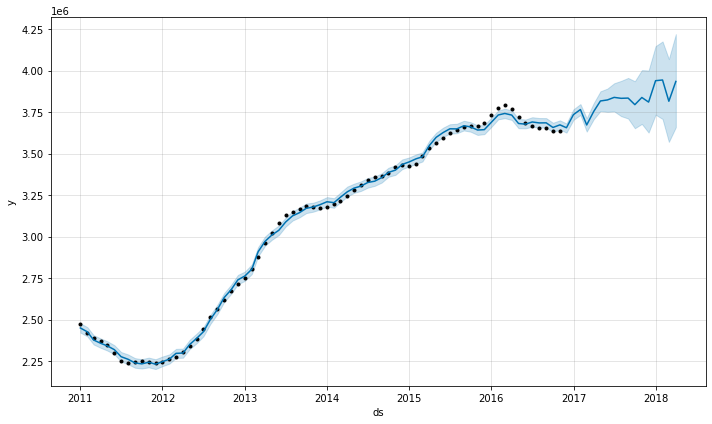

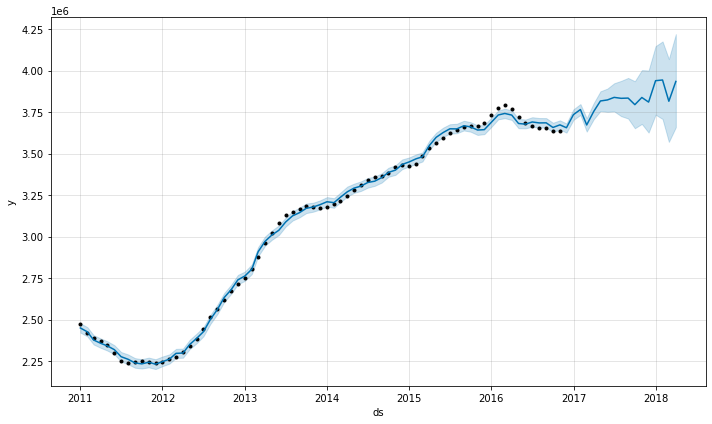

In [108]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 80518.83


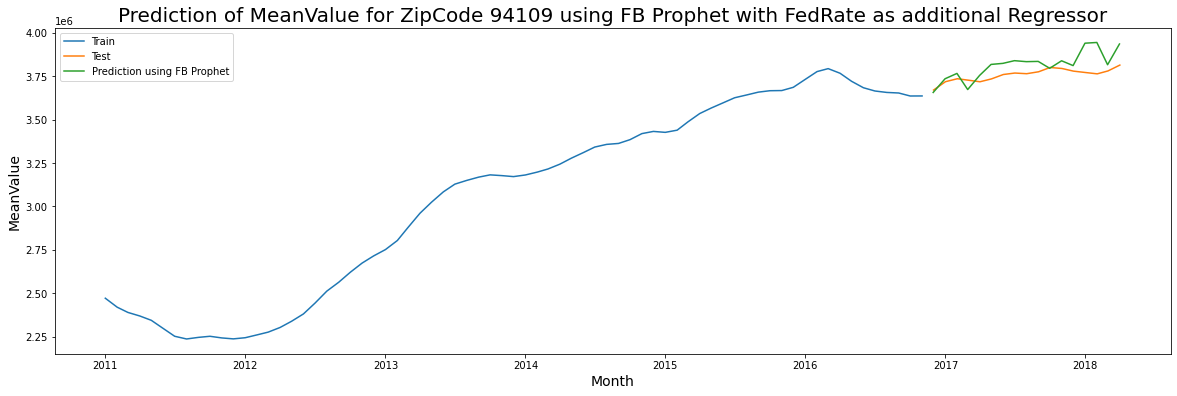

In [109]:
# Predicting the test values using predict function.
train = train_1['MeanValue'] 
forecast= forecast_pred
sqr_mse1 =np.sqrt(mean_squared_error(test_1['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqr_mse1, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94109 using FB Prophet with FedRate as additional Regressor', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_1['MeanValue'], label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94110

In [110]:
#Fit and Forecast for zipcode 94110
m = Prophet()
m.add_regressor('Fed_Rate')
m.fit(df2)

future = m.make_future_dataframe(periods=17, freq='M')
future['Fed_Rate']=features['Fed_Rate']

forecast = m.predict(future)
forecast[['ds','yhat']].tail(17)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
71,2016-11-30,1.373294e+06
72,2016-12-31,1.360536e+06
73,2017-01-31,1.357912e+06
74,2017-02-28,1.323959e+06
75,2017-03-31,1.316775e+06
76,2017-04-30,1.318965e+06
77,2017-05-31,1.322591e+06
78,2017-06-30,1.314237e+06
79,2017-07-31,1.313338e+06
80,2017-08-31,1.315491e+06


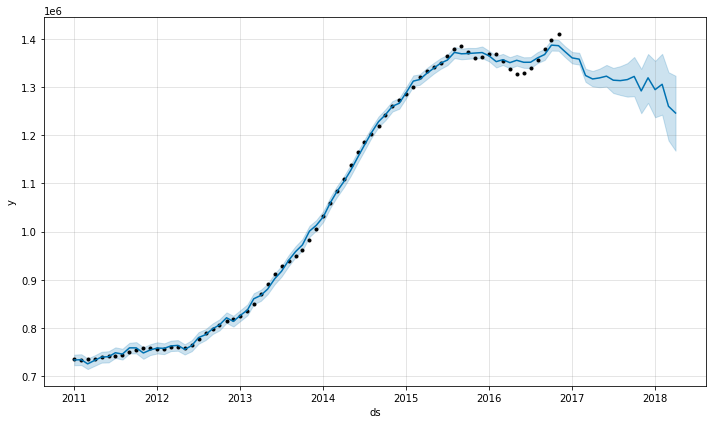

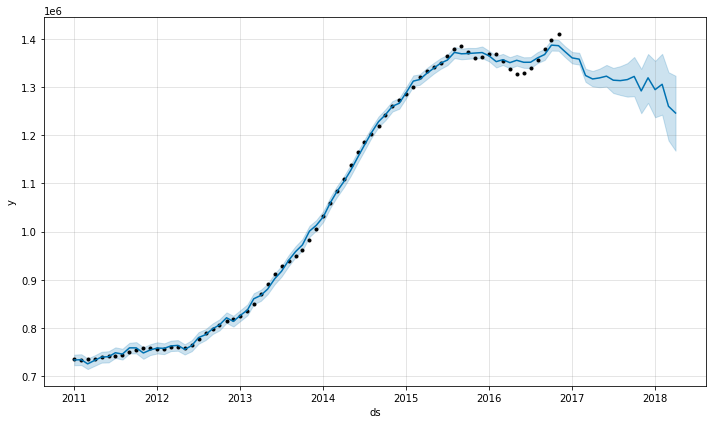

In [111]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 202774.72


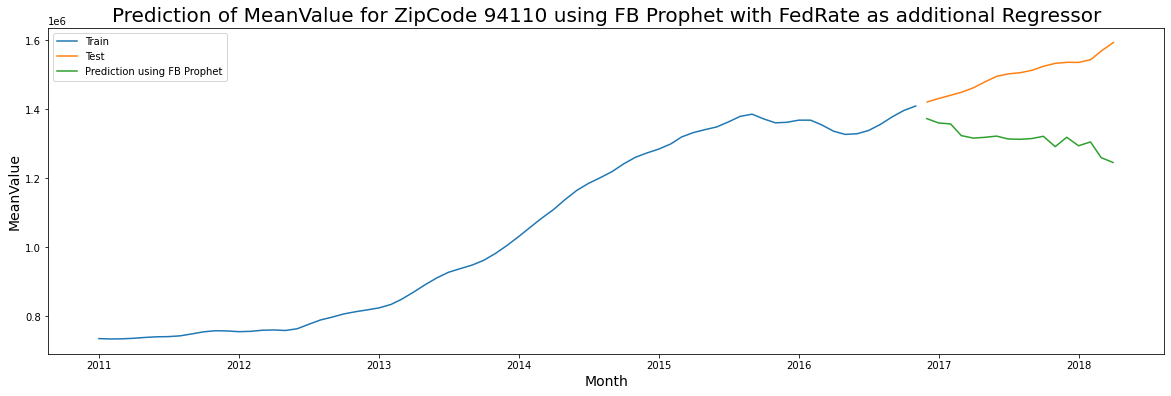

In [112]:
# Predicting the test values using predict function.
train = train_2['MeanValue'] 
forecast= forecast_pred
sqr_mse2 =np.sqrt(mean_squared_error(test_2['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqr_mse2, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94110 using FB Prophet with FedRate as additional Regressor', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_2['MeanValue'], label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94122

In [113]:
#Fit and Forecast for zipcode 94122
m = Prophet()
m.add_regressor('Fed_Rate')
m.fit(df3)

future = m.make_future_dataframe(periods=17, freq='M')
future['Fed_Rate']=features['Fed_Rate']

forecast = m.predict(future)
forecast[['ds','yhat']].tail(17)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
71,2016-11-30,1.232612e+06
72,2016-12-31,1.243887e+06
73,2017-01-31,1.252668e+06
74,2017-02-28,1.255771e+06
75,2017-03-31,1.267051e+06
76,2017-04-30,1.271688e+06
77,2017-05-31,1.275453e+06
78,2017-06-30,1.284288e+06
79,2017-07-31,1.290664e+06
80,2017-08-31,1.304322e+06


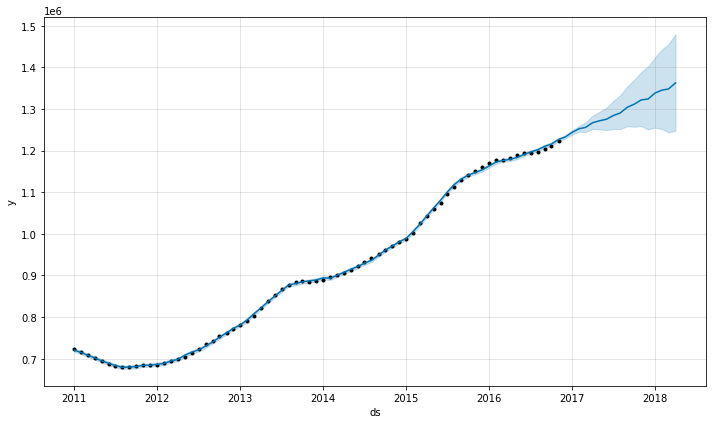

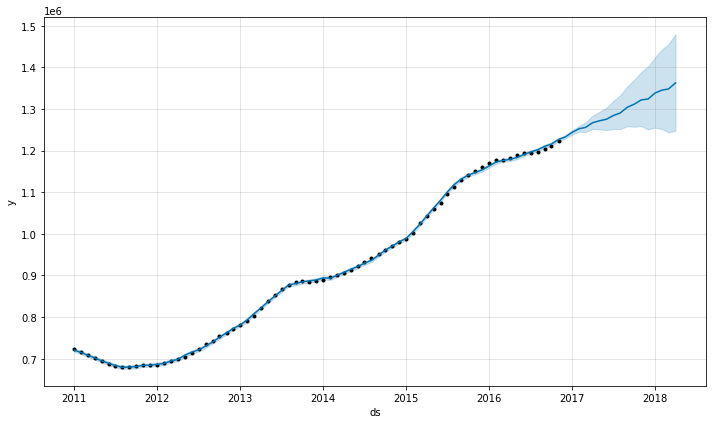

In [114]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 40187.2


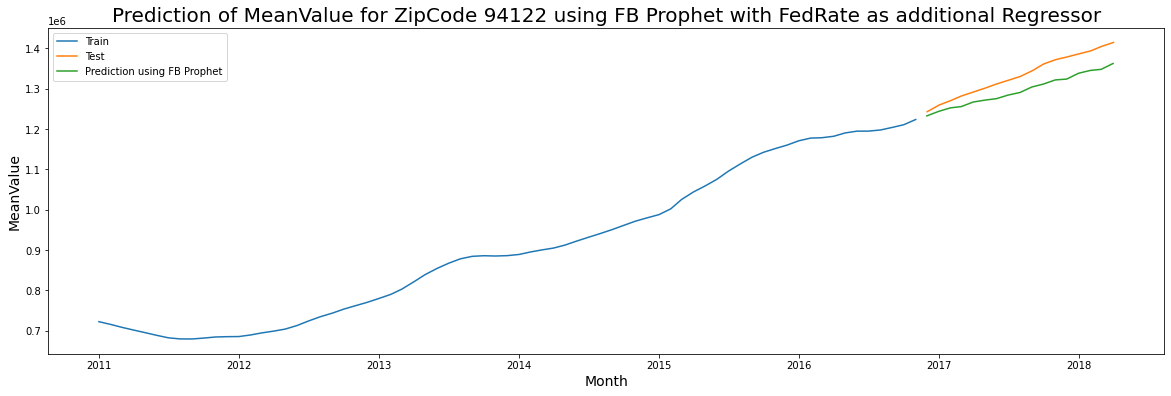

In [115]:
# Predicting the test values using predict function.
train = train_3['MeanValue'] 
forecast= forecast_pred
sqr_mse3 =np.sqrt(mean_squared_error(test_3['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqr_mse3, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94122 using FB Prophet with FedRate as additional Regressor', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_3['MeanValue'], label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94112

In [116]:
#Fit and Forecast for zipcode 94112
m = Prophet()
m.add_regressor('Fed_Rate')
m.fit(df4)

future = m.make_future_dataframe(periods=17, freq='M')
future['Fed_Rate']=features['Fed_Rate']

forecast = m.predict(future)
forecast[['ds','yhat']].tail(17)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
71,2016-11-30,864574.865524
72,2016-12-31,870125.586240
73,2017-01-31,874907.024427
74,2017-02-28,864921.789224
75,2017-03-31,874233.463123
76,2017-04-30,877859.041782
77,2017-05-31,874007.597460
78,2017-06-30,876249.798689
79,2017-07-31,879307.084288
80,2017-08-31,885810.551397


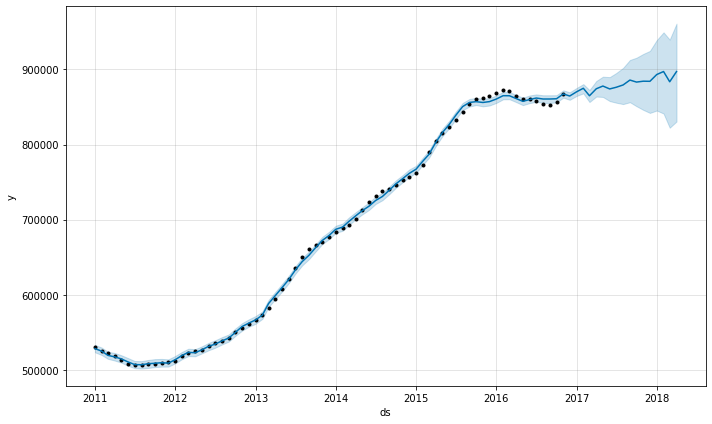

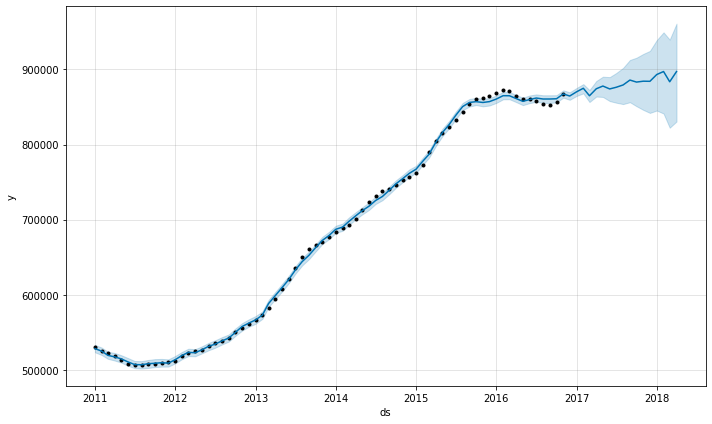

In [117]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 97372.4


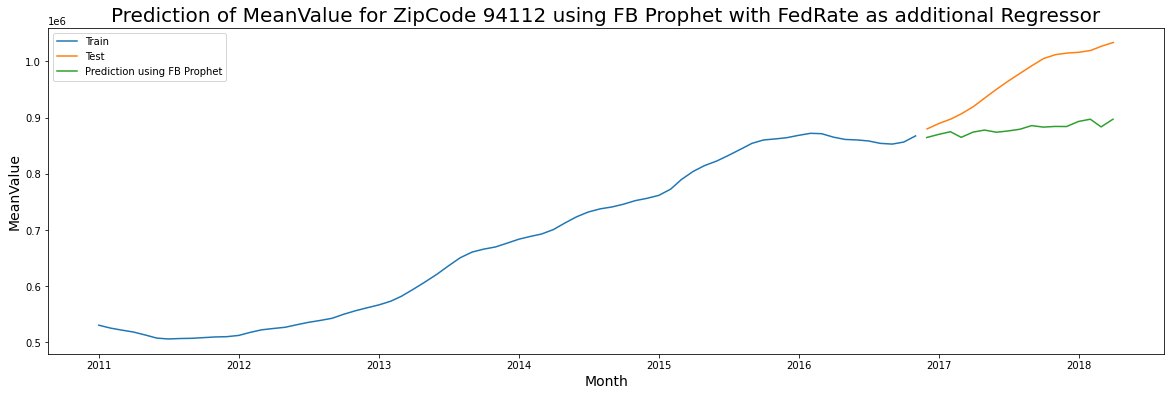

In [118]:
# Predicting the test values using predict function.
train = train_4['MeanValue'] 
forecast= forecast_pred
sqr_mse4 =np.sqrt(mean_squared_error(test_4['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqr_mse4, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94112 using FB Prophet with FedRate as additional Regressor', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_4['MeanValue'], label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

Fit and Forecast for zipcode 94115

In [119]:
#Fit and Forecast for zipcode 94115
m = Prophet()
m.add_regressor('Fed_Rate')
m.fit(df5)

future = m.make_future_dataframe(periods=17, freq='M')
future['Fed_Rate']=features['Fed_Rate']

forecast = m.predict(future)
forecast[['ds','yhat']].tail(17)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
71,2016-11-30,3.878627e+06
72,2016-12-31,3.898891e+06
73,2017-01-31,3.921752e+06
74,2017-02-28,3.867315e+06
75,2017-03-31,3.917136e+06
76,2017-04-30,3.936326e+06
77,2017-05-31,3.937066e+06
78,2017-06-30,3.941128e+06
79,2017-07-31,3.938439e+06
80,2017-08-31,3.952112e+06


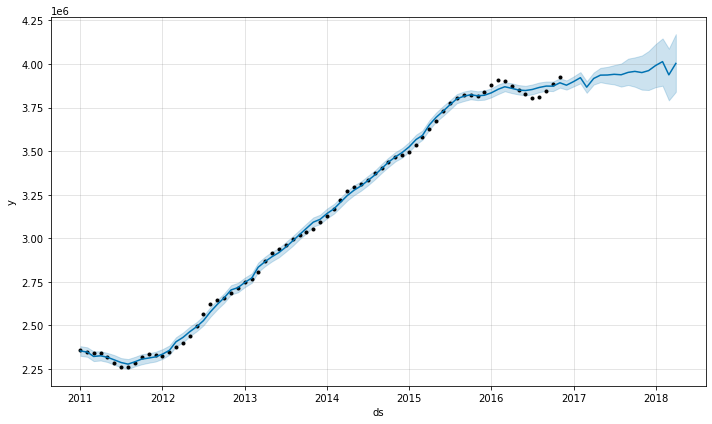

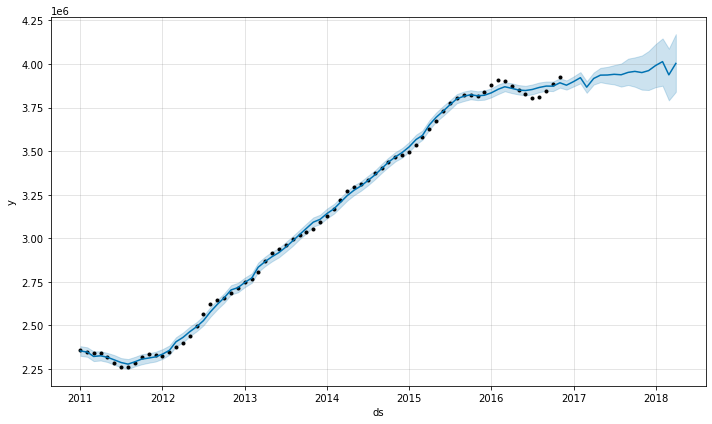

In [120]:
forecast_pred = forecast.tail(17)[['ds','yhat']]
forecast_pred.set_index('ds', inplace=True)
forecast_pred = forecast_pred['yhat']
m.plot(forecast)

The Root Mean Squared Error of our forecasts is 165416.92


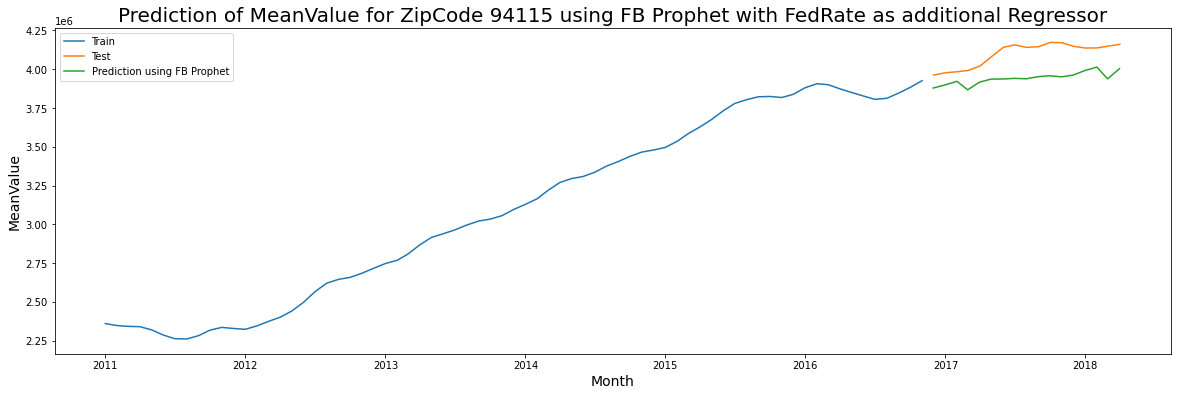

In [121]:
# Predicting the test values using predict function.
train = train_5['MeanValue'] 
forecast= forecast_pred
sqr_mse5 =np.sqrt(mean_squared_error(test_5['MeanValue'],forecast_pred))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(sqr_mse5, 2)))
plt.figure(figsize=(20,6))
plt.title('Prediction of MeanValue for ZipCode 94115 using FB Prophet with FedRate as additional Regressor', fontsize=20)
plt.plot(train, label='Train')
plt.plot(test_5['MeanValue'], label='Test')
plt.plot(forecast, label='Prediction using FB Prophet')
plt.legend(loc='best')
plt.xlabel('Month', fontsize=14)
plt.ylabel('MeanValue', fontsize=14)
plt.show()

MSE for Additional variable

In [123]:
data ={'ZipCode': ['94109','94110','94122','94112','94115'] ,'RMSE (Additional Variable)':[sqr_mse1,sqr_mse2,sqr_mse3,sqr_mse4,sqr_mse5]}
fbp1_mse=pd.DataFrame(data)
fbp1_mse

,ZipCode,RMSE (Additional Variable)
0,94109,80518.834130
1,94110,202774.721548
2,94122,40187.196331
3,94112,97372.404054
4,94115,165416.922588
